In [41]:
import pandas as pd 
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

#downloading data
train_df = pd.read_csv("train.csv")

In [42]:
train_df.head

<bound method NDFrame.head of           id  gender   age  hypertension  heart_disease ever_married  \
0          1    Male  50.0             0              0          Yes   
1          2  Female  52.0             0              0          Yes   
2          3  Female  26.0             0              0           No   
3          4  Female  37.0             0              0          Yes   
4          5    Male  59.0             0              0          Yes   
...      ...     ...   ...           ...            ...          ...   
12238  12239  Female  32.0             0              0          Yes   
12239  12240  Female  31.0             0              0          Yes   
12240  12241    Male  65.0             0              0          Yes   
12241  12242  Female  75.0             0              0          Yes   
12242  12243    Male  58.0             0              0          Yes   

      work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0       Private          Rura

In [43]:
feature_cols = ['gender', 'age', 'hypertension', 'heart_disease','Residence_type','avg_glucose_level','bmi', 'smoking_status']

train, test = train_test_split(train_df, 
                                test_size = .30,
                                random_state = 39)

X_train = train_df[feature_cols] 
y_train = train_df['stroke'] 
X_test = train_df[feature_cols]  
y_test = train_df['stroke']     

X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Add intercept
X_train = sm.add_constant(X_train, has_constant='add')
X_test = sm.add_constant(X_test, has_constant='add')

# Convert to float
X_train = X_train.astype(float)
X_test = X_test.astype(float)

print(X_train.dtypes)
print(y_train.dtypes)

const                             float64
age                               float64
hypertension                      float64
heart_disease                     float64
avg_glucose_level                 float64
bmi                               float64
gender_Male                       float64
gender_Other                      float64
Residence_type_Urban              float64
smoking_status_formerly smoked    float64
smoking_status_never smoked       float64
smoking_status_smokes             float64
dtype: object
int64


In [47]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

continuous_vars = ['age', 'avg_glucose_level', 'bmi']

model_original = sm.GLM(y_train, X_train, family=sm.families.Binomial())
results_original = model_original.fit()

X_train_bt = X_train.copy()
for var in continuous_vars:
    X_train_bt[f'{var}_logint'] = X_train_bt[var] * np.log(X_train_bt[var] + 1)
    
model_bt = sm.GLM(y_train, X_train_bt, family=sm.families.Binomial())
results_bt = model_bt.fit()

# Compare models
print("Original AIC:", results_original.aic)
print("Box–Tidwell AIC:", results_bt.aic)
print("\nBox–Tidwell model summary:")
print(results_bt.summary())

Original AIC: 3132.040479123892
Box–Tidwell AIC: 3134.187694403693

Box–Tidwell model summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                 stroke   No. Observations:                12243
Model:                            GLM   Df Residuals:                    12228
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1552.1
Date:                Wed, 15 Oct 2025   Deviance:                       3104.2
Time:                        18:11:12   Pearson chi2:                 1.61e+04
No. Iterations:                    19   Pseudo R-squ. (CS):            0.08675
Covariance Type:            nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
----------------

In [54]:
glm_train = sm.GLM(y_train,
             X_train,
             family=sm.families.Binomial())
results = glm_train.fit()
print(results.summary())
probs = results.predict(exog=X_test)
glm_pred = (probs >= 0.3).astype(int)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 stroke   No. Observations:                12243
Model:                            GLM   Df Residuals:                    12231
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1554.0
Date:                Wed, 15 Oct 2025   Deviance:                       3108.0
Time:                        18:12:19   Pearson chi2:                 1.10e+04
No. Iterations:                    19   Pseudo R-squ. (CS):            0.08646
Covariance Type:            nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [55]:
print("Accuracy:", accuracy_score(y_test, glm_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, glm_pred))
print("Classification Report:\n", classification_report(y_test, glm_pred))

Accuracy: 0.9549946908437474
Confusion Matrix:
 [[11618   119]
 [  432    74]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98     11737
           1       0.38      0.15      0.21       506

    accuracy                           0.95     12243
   macro avg       0.67      0.57      0.59     12243
weighted avg       0.94      0.95      0.95     12243



In [62]:
from imblearn.over_sampling import SMOTENC
from collections import Counter
import statsmodels.api as sm

print(X_train.columns.tolist())

categorical_cols = ['gender_Male', 'gender_Other', 'heart_disease', 'Residence_type_Urban', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes']

categorical_indices = [X_train.columns.get_loc(col) for col in categorical_cols]

counter = Counter(y_train)
print('Before:', counter)

smt = SMOTENC(categorical_features=categorical_indices, random_state=42)
X_train_sm, y_train_sm = smt.fit_resample(X_train, y_train)

counter = Counter(y_train_sm)
print('After:', counter)

model_smote = sm.GLM(y_train_sm, X_train_sm, family=sm.families.Binomial())
results_smote = model_smote.fit()
print(results_smote.summary())

['const', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'gender_Male', 'gender_Other', 'Residence_type_Urban', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes']
Before: Counter({0: 11737, 1: 506})
After: Counter({0: 11737, 1: 11737})
                 Generalized Linear Model Regression Results                  
Dep. Variable:                 stroke   No. Observations:                23474
Model:                            GLM   Df Residuals:                    23462
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9410.5
Date:                Wed, 15 Oct 2025   Deviance:                       18821.
Time:                        18:27:24   Pearson chi2:                 2.23e+04
No. Iterations:                    19   Pseudo R-squ. (CS):             

In [75]:
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, recall_score, precision_score,
    precision_recall_curve, auc
)
import numpy as np

X_test_aligned = X_test.reindex(columns=X_train_sm.columns, fill_value=0)

probs = results_smote.predict(X_test_aligned) 

for t in [0.3, 0.4, 0.5, 0.6]:
    y_pred_t = (probs >= t).astype(int)
    rec = recall_score(y_test, y_pred_t)
    pre = precision_score(y_test, y_pred_t)
    print(f"Threshold {t:.2f} → Recall(1): {rec:.2f}, Precision(1): {pre:.2f}")

y_pred = (probs >= 0.4).astype(int)

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, probs))

prec, rec, thr = precision_recall_curve(y_test, probs)
pr_auc = auc(rec, prec)
print("PR-AUC:", pr_auc)

Threshold 0.30 → Recall(1): 0.88, Precision(1): 0.10
Threshold 0.40 → Recall(1): 0.81, Precision(1): 0.12
Threshold 0.50 → Recall(1): 0.75, Precision(1): 0.14
Threshold 0.60 → Recall(1): 0.66, Precision(1): 0.16

Accuracy: 0.73642081189251
Confusion Matrix:
 [[8606 3131]
 [  96  410]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.73      0.84     11737
           1       0.12      0.81      0.20       506

    accuracy                           0.74     12243
   macro avg       0.55      0.77      0.52     12243
weighted avg       0.95      0.74      0.82     12243

ROC AUC: 0.8579947674005486
PR-AUC: 0.2216414074978158


ValueError: x and y must have same first dimension, but have shapes (20,) and (40,)

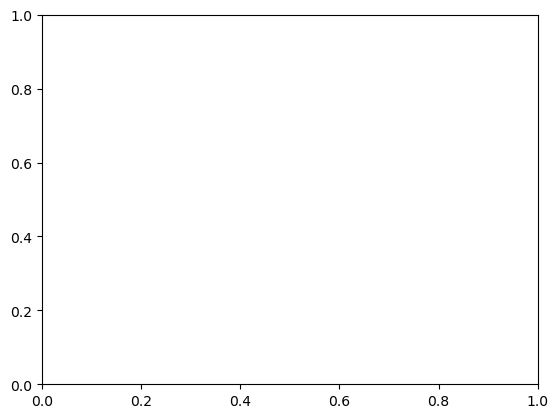

In [89]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_score

for k in k_values:
    knn = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=k))
    ])
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

plt.plot(k_values, cv_scores, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('CV Accuracy')
plt.title('KNN Tuning Curve')
plt.show()

best_k = k_values[np.argmax(cv_scores)]
print(f"Best k = {best_k}, CV Accuracy = {max(cv_scores):.3f}")

In [92]:
knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=10))
])
knn.fit(X_train, y_train)

knn_pred = knn.predict(X_test)

k_values = range(1, 21)
cv_scores = []

In [93]:
print("KNN Accuracy:", accuracy_score(y_test, knn_pred))
print("KNN Confusion Matrix:\n", confusion_matrix(y_test, knn_pred))
print("\nKNN Classification Report:\n", classification_report(y_test, knn_pred))

KNN Accuracy: 0.959160336518827
KNN Confusion Matrix:
 [[11729     8]
 [  492    14]]

KNN Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98     11737
           1       0.64      0.03      0.05       506

    accuracy                           0.96     12243
   macro avg       0.80      0.51      0.52     12243
weighted avg       0.95      0.96      0.94     12243

